# **Network Packet Security Analysis Chatbot using SQL RAG Approach and a Cybersecurity-Tuned LLM**

# **1. Overview**
This project provides an advanced framework for cybersecurity threat analysis through a conversational interface. It empowers security analysts to investigate network traffic data by asking questions in natural language.

The core of this system is segolilylabs/Lily-Cybersecurity-7B-v0.2, a Large Language Model (LLM) specifically fine-tuned for the cybersecurity domain. This specialization allows it to understand the nuances of network protocols, attack patterns, and security-specific terminology, leading to more accurate and relevant analysis.

The framework's main feature is a dual-analysis engine that enables analysts to investigate data using two complementary methods: a Text-to-SQL approach for database-wide queries and a RAG-like approach for deep, context-specific analysis.

# **2. Cybersecurity-Centric Architecture**
The project's architecture is designed to support a typical security analysis workflow, from raw data ingestion to actionable insights. The workflow  explicitly evaluate the two distinct analysis modes derived from from `bizbot.py`: **SQL Data Query** and **AI Security Analysis (RAG)** used in an attack sample of network traffic capture. The final output is a clear Ragas score for each mode, allowing for a direct performance comparison.

**Key Components:**
*   pcap2csv-ok.py: A utility that parses raw packet captures (.pcap) and extracts a curated set of security-relevant features into a CSV file, creating a structured dataset ready for investigation.
*   Segolily LLM (The AI Analyst): The core of the system. As a cybersecurity-tuned LLM, it excels at: Generating precise SQL queries for threat hunting in network logs, Understanding security context to analyze specific events (e.g., a single anomalous connection), Recognizing security-related entities like IP addresses, port numbers, and attack types.
*   Chatbot Application (bizbot.py): The primary interface for the security analyst. Built with Streamlit, it manages data loading and provides access to the dual-analysis engine.

You can create a new Colab notebook and copy-paste the content of each cell.

### **Colab Notebook: Evaluating BizBot's SQL and AI Analysis Modes**

---

### **Part 0: Introduction and Setup**

#### **Cell 1: Introduction (Markdown)**
# Colab Notebook:

This notebook evaluates two core analysis methodologies inspired by the `bizbot.py` script, using the `segolily/Lily-Cybersecurity-7B` model for all AI tasks.

1.  **SQL Data Query Mode**: This section simulates BizBot's Text-to-SQL functionality. We test the LLM's ability to convert a natural language question into an executable SQL query. The evaluation measures if the final answer derived from the query is correct.

2.  **AI Security Analysis (RAG) Mode**: This section simulates BizBot's RAG (Retrieval-Augmented Generation) functionality. In a real RAG system, a retriever would first find relevant information (e.g., specific rows in the CSV). We simulate the final, crucial step: providing this retrieved context to the LLM and testing its ability to accurately answer a question based *only* on that context.

The final output provides a `ragas` score for each mode, allowing for a direct comparison of their accuracy.

**Runtime Requirement**: A GPU is required. In Colab, go to `Runtime > Change runtime time` and select at least `T4 GPU`.


#### **Cell 2: Install Dependencies**

In [ ]:
# Install all required libraries
!pip install -q pandas pandasql
!pip install -q transformers accelerate
!pip install -q datasets langchain ragas
!pip install -q langchain-openai # Install the OpenAI integration for Langchain/Ragas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.7 MB/s eta 0:00:00


---

### **Part 1: Model and Data Preparation**

#### **Cell 3: Load LLM and Tokenizer**

In [ ]:
# Ensure the latest version of bitsandbytes is installed just before use
!pip install -U -q bitsandbytes

# Add a simple check to confirm bitsandbytes is available
try:
    import bitsandbytes as bnb
    print("bitsandbytes installed successfully.")
except ImportError:
    # If this still fails, there's a deeper environment issue or conflict
    print("Error: bitsandbytes not found after installation.")
    # You might consider restarting the runtime if this happens
    # get_ipython().kernel.do_shutdown(True) # Uncomment to force restart

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

# The user-specified model for all analysis tasks
model_name = "segolilylabs/Lily-Cybersecurity-7B-v0.2"

# Use 4-bit quantization to load the 7B model on a Colab GPU
# This requires the bitsandbytes library
# Define quantization_config only if bitsandbytes is available
if 'bnb' in globals() and bnb:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    print("Loading model and tokenizer... (This may take a few minutes)")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Only attempt to load with quantization if bitsandbytes is available
    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=quantization_config,
            torch_dtype=torch.float16,
            device_map="auto", # Automatically use the GPU
        )

        # Create a transformers pipeline for easier text generation
        hf_pipeline = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=150,
            temperature=0.01, # Set low for factual, deterministic outputs
        )
        print("Model loaded successfully.")

    except Exception as e:
        print(f"An error occurred during model loading: {e}")
        print("Please ensure you have a GPU runtime enabled (Runtime -> Change runtime type -> T4 GPU).")
        print("If using a GPU, consider restarting the Colab runtime (Runtime -> Restart runtime) and trying again.")
else:
    print("bitsandbytes is not available. Cannot load model with 4-bit quantization.")
    print("Ensure you have a GPU runtime enabled and bitsandbytes installs correctly.")

bitsandbytes installed successfully.
Loading model and tokenizer... (This may take a few minutes)


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use cuda:0


Model loaded successfully.



#### **Cell 4: Cybersecurity LLM generated answer**
This function takes a natural language question and the schema (column names) of a Pandas DataFrame as input. Its goal is to use the loaded Large Language Model (LLM), in this case the [Segolily-Cybersecurity-7b](https://huggingface.co/segolilylabs/Lily-Cybersecurity-7B-v0.2) to convert the question into a SQL query and then run that query against the DataFrame to get an answer.

In [ ]:
if 'hf_pipeline' in globals() and 'pysqldf' in globals() and 'df' in globals():
    def text_to_sql_and_execute(natural_language_question, dataframe_schema):
        """
        Uses the Segolily LLM (hf_pipeline) to convert a natural language question
        into a SQL query, then executes the query against the dataframe.
        """
        # 1. Craft a prompt for the Segolily LLM to generate SQL
        # Provide the dataframe schema so the LLM knows the table name ('df') and column names
        # You might need to experiment with the prompt structure for best results with your LLM
        prompt_for_sql_generation = f"""
You are a helpful assistant that translates natural language questions into SQL queries for a pandas DataFrame named 'df'.
The DataFrame 'df' has the following columns: {dataframe_schema}.
Generate a concise SQL query that answers the following question based on the 'df' DataFrame.
Only return the SQL query and nothing else.

Question: {natural_language_question}

SQL Query:
"""

        # 2. Use the Segolily LLM (hf_pipeline) to generate the SQL query
        # Adjust parameters like max_new_tokens and stop_sequence if needed
        # Set stop_sequence to prevent the LLM from generating extra text after the query
        try:
            sql_generation_response = hf_pipeline(
                prompt_for_sql_generation,
                max_new_tokens=100, # Adjust based on expected query length
                do_sample=False, # Aim for deterministic output
                pad_token_id=hf_pipeline.tokenizer.eos_token_id # Needed for some models
                # Add other parameters as needed by your pipeline/model
            )[0]['generated_text']

            # Extract the generated SQL query from the response
            # This parsing might need adjustment based on how the LLM formats its output
            # Assuming the LLM output starts with "SQL Query:" and we want everything after it
            generated_sql = sql_generation_response.split("SQL Query:")[-1].strip()

        except Exception as e:
            print(f"Error during LLM SQL generation for question '{natural_language_question}': {e}")
            generated_sql = "SELECT 'Error: LLM failed to generate SQL';" # Default to an error query for robustness

        # 3. Execute the generated SQL query using pysqldf
        model_answer_string = "Error: Could not execute SQL."
        try:
            # IMPORTANT: Check if the generated_sql is not empty or an error string before executing
            if generated_sql and not generated_sql.startswith("SELECT 'Error:") and generated_sql.lower().strip().startswith("select"):
                 # Some basic validation to ensure it looks like a SELECT query
                 model_answer_df = pysqldf(generated_sql)
                 # Convert the result DataFrame to a string for comparison
                 model_answer_string = model_answer_df.to_string(index=False)
            else:
                 model_answer_string = "Error: LLM generated invalid or empty SQL."

        except Exception as e:
            print(f"Error executing LLM-generated SQL query: {generated_sql} - Error: {e}")
            model_answer_string = f"Error executing LLM-generated SQL: {e}"


        # 4. Return the generated answer string, the generated SQL, and potentially the raw LLM response
        return model_answer_string, generated_sql, sql_generation_response
    print("text_to_sql_and_execute function defined successfully.")
else:
    print("Dependencies (hf_pipeline, pysqldf, df) not available. Cannot define text_to-sql_and_execute function.")

text_to_sql_and_execute function defined successfully.


#### **Cell 4: Load and Prepare the ToN-IoT Dataset as a "Database"**
The TON_IoT datasets are new generations of Industry 4.0/Internet of Things (IoT) and Industrial IoT (IIoT) datasets for evaluating the fidelity and efficiency of different cybersecurity applications based on Artificial Intelligence (AI). The datasets have been called 'ToN_IoT' as they include heterogeneous data sources collected from Telemetry datasets of IoT and IIoT sensors, Operating systems datasets of Windows 7 and 10 as well as Ubuntu 14 and 18 TLS and Network traffic datasets. The testbed was deployed using multiple virtual machines and hosts of windows, Linux and Kali operating systems to manage the interconnection between the three layers of IoT, Cloud and Edge/Fog systems. Various attacking techniques, such as DoS, DDoS and ransomware, against web applications, IoT gateways and computer systems across the IoT/IIoT network.  The datasets were gathered in a parallel processing to collect several normal and cyber-attack events from network traffic, Windows audit traces, Linux audit traces, and telemetry data of IoT services. The datasets can be found here https://research.unsw.edu.au/projects/toniot-datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from pandasql import sqldf

# Define the path to your CSV file in Google Drive
# IMPORTANT: Replace 'Your_Folder_Name' with the actual path to your folder in Drive
# Example: If the file is in a folder named 'iot_data' directly in your Drive's root,
# the path might be '/content/drive/MyDrive/iot_data/ML-EdgeIIoT-dataset.csv'
# If it's in 'My Drive/Colab Notebooks/data/ML-EdgeIIoT-dataset.csv', the path is
# '/content/drive/MyDrive/Colab Notebooks/data/ML-EdgeIIoT-dataset.csv'

# !!! REPLACE THIS WITH YOUR ACTUAL FILE PATH IN GOOGLE DRIVE !!!
LABELED_CSV_FILE = '/content/.../sampled_toniot_dataset.csv'

print(f"Attempting to load dataset from Google Drive: {LABELED_CSV_FILE}")

# Check if the file exists before trying to load
if not os.path.exists(LABELED_CSV_FILE):
    print(f"Error: File not found at '{LABELED_CSV_FILE}'")
    print("Please double-check the path in Google Drive.")
    print("Make sure Google Drive is mounted and the path copied from the Colab file explorer is correct.")
    # You might want to stop execution here if the file isn't found
    # raise FileNotFoundError(f"Dataset not found at {LABELED_CSV_FILE}")
else:
    print("File found. Loading into pandas DataFrame...")
    # Load the data into a pandas DataFrame
    # Use appropriate encoding if necessary (e.g., encoding='latin1')
    try:
        # It's common for IoT datasets to have encoding issues, try 'latin1' or others if utf-8 fails
        try:
            df = pd.read_csv(LABELED_CSV_FILE)
        except UnicodeDecodeError:
            print("UTF-8 decode failed, trying latin1 encoding...")
            df = pd.read_csv(LABELED_CSV_FILE, encoding='latin1')
        except Exception as e:
            print(f"An unexpected error occurred while reading the CSV: {e}")
            # Re-raise the exception if it's not a decoding issue we handled
            raise e


    except FileNotFoundError:
         print(f"Error: File not found at '{LABELED_CSV_FILE}'. Please ensure the path is correct.")
         # Handle or re-raise the error as appropriate
         # raise
    except Exception as e:
        print(f"An error occurred while loading the CSV file: {e}")
        print("Please check the file format and content.")
        # Handle or re-raise the error as appropriate
        # raise


    # IMPORTANT: Clean column names to be SQL-friendly (replace dots and spaces/special chars)
    # Also handle potential leading/trailing whitespace in column names
    df.columns = df.columns.str.strip().str.replace('[^a-zA-Z0-9_]', '_', regex=True)

    # This function allows us to query the pandas DataFrame using SQL syntax
    pysqldf = lambda q: sqldf(q, globals())

    print("Data loaded. Columns are now SQL-friendly.")
    print("\n--- DataFrame Head ---")
    display(df.head()) # Use display instead of print for better formatting in Colab

    # Optional: Print info about the dataframe to verify
    print("\n--- DataFrame Info ---")
    df.info()

Attempting to load dataset from Google Drive: /content/drive/MyDrive/PHDS/experiment/bizbot-segolily/toniot-dataset/sampled_toniot_dataset.csv
File found. Loading into pandas DataFrame...
Data loaded. Columns are now SQL-friendly.

--- DataFrame Head ---


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,dst_ip_bytes,dns_query,dns_rejected,ssl_version,ssl_cipher,http_method,http_uri,http_version,label,type
0,192.168.1.193,49739,192.168.1.33,80,tcp,-,0.000018,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49401,192.168.1.37,8080,tcp,-,0.000138,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49663,192.168.1.33,80,tcp,-,0.000022,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49345,192.168.1.37,8080,tcp,-,0.000009,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49875,192.168.1.37,8080,tcp,-,0.000142,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   src_ip        1000 non-null   object 
 1   src_port      1000 non-null   int64  
 2   dst_ip        1000 non-null   object 
 3   dst_port      1000 non-null   int64  
 4   proto         1000 non-null   object 
 5   service       1000 non-null   object 
 6   duration      1000 non-null   float64
 7   src_bytes     1000 non-null   int64  
 8   dst_bytes     1000 non-null   int64  
 9   conn_state    1000 non-null   object 
 10  missed_bytes  1000 non-null   int64  
 11  src_pkts      1000 non-null   int64  
 12  src_ip_bytes  1000 non-null   int64  
 13  dst_pkts      1000 non-null   int64  
 14  dst_ip_bytes  1000 non-null   int64  
 15  dns_query     1000 non-null   object 
 16  dns_rejected  1000 non-null   object 
 17  ssl_version   1000 non-null   object 
 18  ssl_c

In [ ]:
if 'df' in globals():
        print(df['type'].unique())

['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'password'
 'ransomware' 'scanning' 'xss']


In [ ]:
if 'df' in globals():
    print("Columns in the dataset:")
    print(df.columns.tolist())
else:
    print("DataFrame 'df' not found. Please ensure Cell 4 ran successfully and the dataset was loaded correctly.")

Columns in the dataset:
['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'http_method', 'http_uri', 'http_version', 'label', 'type']


---

### **Part 2: SQL Data Query Mode Evaluation**

#### **Cell 5: Define and Simulate the SQL Mode Process**

In [ ]:
# Ensure df and pysqldf are available from previous cells
if 'df' in globals() and 'pysqldf' in globals():
    query_to_get_ddos_count = "SELECT DISTINCT src_ip FROM df WHERE type = 'mitm';"
    try:
        actual_ddos_count_df = pysqldf(query_to_get_ddos_count)
        # Convert the result DataFrame to a string, without the index
        actual_ddos_count_string = actual_ddos_count_df.to_string(index=False)
        print("What are the source IP addresses involved in 'MITM' attacks? Show only unique IPs.")
        print(actual_ddos_count_string)
    except Exception as e:
        print(f"Error executing SQL query: {e}")
else:
    print("DataFrame 'df' or function 'pysqldf' not found. Please run Cell 4.")

What are the source IP addresses involved in 'MITM' attacks? Show only unique IPs.
       src_ip
 192.168.1.34
 192.168.1.31
192.168.1.152


In [ ]:
from datasets import Dataset
import random
import pandas as pd
from pandasql import sqldf

# Ensure the DataFrame 'df' and the function 'pysqldf' are available from Cell 4
# If not, you would need to re-run Cell 4 or ensure they are in the global scope.

# --- IMPORTANT: Define questions and the *correct* SQL queries to get the ground truth ---
# You MUST define the correct SQL query for each question here.
# These queries will be executed to get the ground truth.
# Use the 'type' column for specific attack names (e.g., 'ddos', 'normal', 'mitm')
# Use the 'label' column only if querying the binary label (0 or 1)

sql_eval_data_with_queries = [
    {
        "question": "How many connections are classified as 'backdoor' attacks?",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE type = 'backdoor';"
    },
    {
        "question": "How many connections are classified as 'ddos' attacks?",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE type = 'ddos';"
    },
    {
        "question": "What are the source IP addresses involved in 'mitm' attacks? Show only unique IPs.",
        "ground_truth_query": "SELECT DISTINCT src_ip FROM df WHERE type = 'mitm';"
    },
    {
        "question": "Count the total number of unique destination IP addresses that experienced attacks (where the binary label is 1).",
        # Query uses the 'label' column for binary classification 1 (attack)
        "ground_truth_query": "SELECT COUNT(DISTINCT dst_ip) FROM df WHERE label = 1;"
    },
     {
        "question": "What is the average duration of 'dos' attacks?",
        "ground_truth_query": "SELECT AVG(duration) FROM df WHERE type = 'dos';"
    },
    {
        "question": "List the unique protocols used in 'injection' attacks.", # Changed 'sql_injection' to 'injection' based on unique values
        "ground_truth_query": "SELECT DISTINCT proto FROM df WHERE type = 'injection';" # Changed 'sql_injection' to 'injection'
    },
    {
        "question": "Count the number of connections for each traffic type (exclude 'normal').", # Changed 'attack type' and 'Benign' to 'traffic type' and 'normal'
        "ground_truth_query": "SELECT type, COUNT(*) FROM df WHERE type != 'normal' GROUP BY type;" # Changed 'benign' to 'normal'
    },
    {
        "question": "Find connections that are 'ddos' attacks with a duration greater than 10 seconds.",
        "ground_truth_query": "SELECT * FROM df WHERE type = 'ddos' AND duration > 10;"
    },
    # Removed question about 'maliciousactivity' as it's not in unique types
    # {
    #     "question": "What is the maximum number of packets sent in a connection labeled as 'maliciousactivity'?",
    #     "ground_truth_query": "SELECT MAX(src_pkts + dst_pkts) FROM df WHERE type = 'maliciousactivity';"
    # },
    {
        "question": "List the destination ports that are commonly targeted by 'scanning' attacks. Show unique ports.", # Changed 'portscan' to 'scanning'
        "ground_truth_query": "SELECT DISTINCT dst_port FROM df WHERE type = 'scanning';" # Changed 'portscan' to 'scanning'
    },
    {
        "question": "Count the number of connections where the 'conn_state' indicates a potential scanning attempt (e.g., 'S0').",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE conn_state = 'S0';"
    },
    {
        "question": "What is the average 'bytes' transferred in connections labeled as 'normal' vs 'ddos'?", # Changed 'benign' to 'normal'
        "ground_truth_query": "SELECT type, AVG(src_bytes + dst_bytes) FROM df WHERE type IN ('normal', 'ddos') GROUP BY type;" # Changed 'benign' to 'normal'
    },
    {
        "question": "Find source IP addresses that initiated more than 1000 connections, and list their count.",
        "ground_truth_query": "SELECT src_ip, COUNT(*) FROM df GROUP BY src_ip HAVING COUNT(*) > 1000;"
    },
    {
        "question": "List the unique 'service' values present in connections with the 'conn_state' 'RST'.",
        "ground_truth_query": "SELECT DISTINCT service FROM df WHERE conn_state = 'RST';"
    },
    {
        "question": "Count connections where the source IP and destination IP are the same (potential internal scanning/loopback).",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE src_ip = dst_ip;"
    },
    {
        "question": "What are the most frequent destination ports in the dataset?",
        "ground_truth_query": "SELECT dst_port, COUNT(*) FROM df GROUP BY dst_port ORDER BY COUNT(*) DESC LIMIT 10;"
    },
    {
        "question": "Find connections with a very short duration (e.g., less than 0.001 seconds) and a large number of packets (e.g., > 10), which could indicate unusual activity.",
        "ground_truth_query": "SELECT * FROM df WHERE duration < 0.001 AND (src_pkts + dst_pkts) > 10;"
    },
    {
        "question": "Count the number of unique pairs of source IP and destination IP addresses.",
        "ground_truth_query": "SELECT COUNT(*) FROM (SELECT DISTINCT src_ip, dst_ip FROM df);"
    },
     {
        "question": "What is the minimum duration for 'normal' connections?", # Changed 'benign' to 'normal'
        "ground_truth_query": "SELECT MIN(duration) FROM df WHERE type = 'normal';" # Changed 'benign' to 'normal'
    },
    {
        "question": "List the unique connection states observed in 'ddos' attacks.",
        "ground_truth_query": "SELECT DISTINCT conn_state FROM df WHERE type = 'ddos';"
    },
    {
        "question": "Count connections with a 'bytes' value of 0 but a duration greater than 0 (potential signaling or control traffic).",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE (src_bytes + dst_bytes) = 0 AND duration > 0;"
    },
    {
        "question": "What are the top 5 'service' types involved in attacks (where binary label is 1)?",
        # Query uses the 'label' column for binary classification 1 (attack)
        "ground_truth_query": "SELECT service, COUNT(*) FROM df WHERE label = 1 GROUP BY service ORDER BY COUNT(*) DESC LIMIT 5;"
    },
    {
        "question": "Find connections originating from source IP '192.168.1.100' that are classified as attacks (where binary label is 1).",
        # Query uses the 'label' column for binary classification 1 (attack)
        "ground_truth_query": "SELECT * FROM df WHERE src_ip = '192.168.1.100' AND label = 1;"
    },
    {
        "question": "Count the number of 'FIN' connection states observed for 'TCP' protocol connections.",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE proto = 'TCP' AND conn_state = 'FIN';"
    },
    {
        "question": "What is the average number of 'packets' for connections with destination port 22 (SSH)?",
        "ground_truth_query": "SELECT AVG(src_pkts + dst_pkts) FROM df WHERE dst_port = 22;"
    },
    {
        "question": "List source IPs and the number of connections they initiated, where the connections are labeled as 'scanning'.", # Changed 'portscan' to 'scanning'
        "ground_truth_query": "SELECT src_ip, COUNT(*) FROM df WHERE type = 'scanning' GROUP BY src_ip;" # Changed 'portscan' to 'scanning'
    },
     {
        "question": "Count connections where the duration is 0 and the bytes transferred is also 0 (potential connection attempts with no data).",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE duration = 0 AND (src_bytes + dst_bytes) = 0;"
    },
    {
        "question": "What is the sum of 'bytes' for connections involving destination port 80 (HTTP)?",
        "ground_truth_query": "SELECT SUM(src_bytes + dst_bytes) FROM df WHERE dst_port = 80;"
    },
    {
        "question": "Find connections with a very high duration (e.g., > 100 seconds) and a 'conn_state' indicating an ongoing or hung connection (e.g., 'EST').",
        "ground_truth_query": "SELECT * FROM df WHERE duration > 100 AND conn_state = 'EST';"
    },
    {
        "question": "Count the number of unique source IP addresses that initiated 'ddos' attacks.",
        "ground_truth_query": "SELECT COUNT(DISTINCT src_ip) FROM df WHERE type = 'ddos';"
    },
    {
        "question": "What are the unique combinations of traffic 'type' and 'proto'?", # Changed 'attack type' to 'traffic type'
        "ground_truth_query": "SELECT DISTINCT type, proto FROM df;"
    },
    {
        "question": "Count connections where the destination port is less than 1024 and the connection type is not 'normal'.", # Changed 'benign' to 'normal'
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE dst_port < 1024 AND type != 'normal';" # Changed 'benign' to 'normal'
    },
    {
        "question": "List the top 5 source IP addresses involved in 'dos' attacks by connection count.",
        "ground_truth_query": "SELECT src_ip, COUNT(*) FROM df WHERE type = 'dos' GROUP BY src_ip ORDER BY COUNT(*) DESC LIMIT 5;"
    },
    {
        "question": "What is the average number of 'bytes' transferred in connections with the 'conn_state' 'RST'?",
        "ground_truth_query": "SELECT AVG(src_bytes + dst_bytes) FROM df WHERE conn_state = 'RST';"
    },
     {
        "question": "Find connections labeled as 'injection' (in the 'type' column) and list their source and destination IPs.", # Changed 'Web Attack - SQL Injection' to 'injection'
        "ground_truth_query": "SELECT src_ip, dst_ip FROM df WHERE type = 'injection';" # Changed 'Web Attack - SQL Injection' to 'injection'
    },
    {
        "question": "Count connections where the 'service' is 'dns' and the 'proto' is 'UDP'.",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE service = 'dns' AND proto = 'UDP';"
    },
    {
        "question": "What is the sum of 'packets' for connections classified as 'scanning'?", # Changed 'portscan' to 'scanning'
        "ground_truth_query": "SELECT SUM(src_pkts + dst_pkts) FROM df WHERE type = 'scanning';" # Changed 'portscan' to 'scanning'
    },
    {
        "question": "List the unique 'conn_state' values and their counts for connections where the 'type' is 'normal'.", # Changed 'benign' to 'normal'
        "ground_truth_query": "SELECT conn_state, COUNT(*) FROM df WHERE type = 'normal' GROUP BY conn_state;" # Changed 'benign' to 'normal'
    },
     {
        "question": "Count connections where the source port is the same as the destination port (potential unusual activity or misconfiguration).",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE src_port = dst_port;"
    },
    {
        "question": "What is the average duration of connections with a 'SYN' connection state?",
        "ground_truth_query": "SELECT AVG(duration) FROM df WHERE conn_state = 'SYN';" # Adjust state if 'SYN' is not relevant in your dataset.
    },
    {
        "question": "Find connections where the destination IP is a broadcast or multicast address (e.g., 255.255.255.255 or starting with 224.), and list their types.",
        "ground_truth_query": "SELECT type FROM df WHERE dst_ip LIKE '255.255.255.%' OR dst_ip LIKE '224.%';" # Adjust IP ranges as needed.
    },
     {
        "question": "Count connections where the number of bytes transferred is 0 for 'TCP' protocol connections.",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE (src_bytes + dst_bytes) = 0 AND proto = 'TCP';"
    },
    {
        "question": "What are the unique connection states observed in 'ddos' attacks?",
        "ground_truth_query": "SELECT DISTINCT conn_state FROM df WHERE type = 'ddos';"
    },
    {
        "question": "Count connections where the destination port is less than 1000 and the 'conn_state' is 'REJ' (potential firewall block on common services).",
        "ground_truth_query": "SELECT COUNT(*) FROM df WHERE dst_port < 1000 AND conn_state = 'REJ';" # Adjust port range and state as relevant.
    },
    {
        "question": "List source IPs and the number of connections they initiated, where the connections have a 'bytes' value of 0 and the type is not 'normal'.", # Changed 'benign' to 'normal'
        "ground_truth_query": "SELECT src_ip, COUNT(*) FROM df WHERE (src_bytes + dst_bytes) = 0 AND type != 'normal' GROUP BY src_ip;" # Changed 'benign' to 'normal'
    },
]

# Select at least 30 questions. If the list has more than 30, select a random subset.
sql_eval_subset_with_queries = sql_eval_data_with_queries
if len(sql_eval_data_with_queries) < 30:
    print(f"Warning: Only {len(sql_eval_data_with_queries)} questions available. Please add more cybersecurity-relevant question-ground truth pairs to 'sql_eval_data_with_queries' to reach at least 30.")
    # If you absolutely need 30 for the evaluation to run, you could potentially
    # duplicate some entries, but this will skew the evaluation results.
    # while len(sql_eval_subset_with_queries) < 30:
    #     sql_eval_subset_with_queries.append(random.choice(sql_eval_data_with_queries))
elif len(sql_eval_data_with_queries) > 30:
     sql_eval_subset_with_queries = random.sample(sql_eval_data_with_queries, 30) # Select exactly 30 random questions


sql_results = []
# Ensure 'df' exists and get its columns if it was successfully loaded in Cell 4
schema = df.columns.tolist() if 'df' in globals() and not df.empty else []

if not schema:
    print("Error: DataFrame 'df' not found or is empty. Please ensure Cell 4 ran successfully and the dataset was loaded correctly.")
else:
    print(f"Simulating SQL queries for {len(sql_eval_subset_with_queries)} cybersecurity-relevant questions based on the loaded dataset...")

    for item in sql_eval_subset_with_queries:
        question = item["question"]
        ground_truth_query = item["ground_truth_query"]

        # Execute the ground truth query to get the actual result
        try:
            ground_truth_df = pysqldf(ground_truth_query)
            ground_truth_string = ground_truth_df.to_string(index=False)
        except Exception as e:
            print(f"Error executing GROUND TRUTH SQL query for question '{question}': {e}")
            ground_truth_string = f"ERROR executing ground truth query: {e}"
            # You might want to skip this question if ground truth cannot be generated
            # continue


        # Simulate the model's text-to-sql process to get the model's answer and query
        model_answer, generated_sql, _ = text_to_sql_and_execute(question, schema)

        sql_results.append({
            "question": question,
            "answer": model_answer,
            "ground_truth": ground_truth_string, # Use the dynamically generated ground truth
            "contexts": [f"Generated SQL: {generated_sql}"] # Using generated SQL as context for Ragas evaluation
        })

    sql_eval_dataset = Dataset.from_list(sql_results)
    print("--- SQL Evaluation Dataset (with generated answers and dynamic ground truths) ---")
    print(f"Dataset size: {len(sql_eval_dataset)}")
    if len(sql_eval_dataset) > 0:
        print("First item:")
        print(sql_eval_dataset[0])
    else:
        print("No evaluation data generated. Check for errors during simulation.")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Simulating SQL queries for 30 cybersecurity-relevant questions based on the loaded dataset...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

--- SQL Evaluation Dataset (with generated answers and dynamic ground truths) ---
Dataset size: 30
First item:
{'question': "Count connections where the 'service' is 'dns' and the 'proto' is 'UDP'.", 'answer': 'Error: LLM generated invalid or empty SQL.', 'ground_truth': ' COUNT(*)\n        0', 'contexts': ["Generated SQL: ```sql\nSELECT COUNT(*)\nFROM df\nWHERE service = 'dns' AND proto = 'UDP';\n```"]}


In [ ]:
# Display the first 10 question-ground truth pairs from the SQL evaluation dataset in a table
if 'sql_eval_dataset' in globals():
    print("--- First 10 SQL Evaluation Pairs (Table Format) ---")
    data_to_display = []
    for i in range(min(10, len(sql_eval_dataset))):
        data_to_display.append({
            "Pair #": i + 1,
            "Question": sql_eval_dataset[i]['question'],
            "Ground Truth": sql_eval_dataset[i]['ground_truth']
        })

    # Create a pandas DataFrame for easy tabular printing
    display_df = pd.DataFrame(data_to_display)
    display(display_df) # Use display() for better table rendering in Colab
else:
    print("SQL evaluation dataset 'sql_eval_dataset' not found. Please run Cell 6 first.")

--- First 10 SQL Evaluation Pairs (Table Format) ---


,Pair #,Question,Ground Truth
0,1,Count connections where the 'service' is 'dns'...,COUNT(*)\n 0
1,2,Count connections where the destination port i...,COUNT(*)\n 752
2,3,Count connections where the source port is the...,COUNT(*)\n 107
3,4,What are the most frequent destination ports i...,dst_port COUNT(*)\n 80 370\n ...
4,5,Find connections with a very short duration (e...,"Empty DataFrame\nColumns: [src_ip, src_port, d..."
5,6,Count connections where the duration is 0 and ...,COUNT(*)\n 253
6,7,Find connections with a very high duration (e....,"Empty DataFrame\nColumns: [src_ip, src_port, d..."
7,8,What are the top 5 'service' types involved in...,service COUNT(*)\n - 564\n http ...
8,9,What is the average duration of connections wi...,AVG(duration)\n None
9,10,Count connections with a 'bytes' value of 0 bu...,COUNT(*)\n 333


In [ ]:
# prompt: Using dataframe display_df: length scatter

import altair as alt
# Calculate the length of the 'Question' and 'Ground Truth' columns
display_df['Question_Length'] = display_df['Question'].str.len()
display_df['Ground_Truth_Length'] = display_df['Ground Truth'].str.len()
# Create a scatter plot with 'Question_Length' on the x-axis and 'Ground_Truth_Length' on the y-axis
chart = alt.Chart(display_df).mark_point().encode(
    x='Question_Length',
    y='Ground_Truth_Length'
)
chart

alt.Chart(...)

In [ ]:
# prompt: Using dataframe display_df: scatter plot

import altair as alt

# Create a scatter plot of 'Pair #' vs 'Ground Truth'
chart = alt.Chart(display_df).mark_point().encode(
    x='Pair #',
    y='Ground Truth'
)

# Display the chart
chart

alt.Chart(...)

Visual: This scatter plot visualizes the relationship between the lengths of questions and their corresponding ground truths, with the x-axis representing question length and the y-axis representing ground truth length. The data points are mostly clustered in the middle range, indicating that moderate-length questions tend to have moderate-length ground truths. However, there is noticeable variability, with some shorter questions paired with longer ground truths and vice versa. This suggests that while there is a general trend of moderate-length pairings, the lengths of questions and ground truths do not always correspond directly, highlighting variability in the dataset.

Visual1: This scatter plot examines the relationship between the lengths of questions and their corresponding ground truths, with the x-axis representing question length and the y-axis representing ground truth length. The data reveals a notable outlier where a very long ground truth (approximately 4.5 million characters) corresponds to a relatively short question (around 80 characters), suggesting a significant imbalance in length for this particular pair. The remaining data points cluster at the lower end of the plot, indicating that most questions and ground truths are relatively short, with lengths generally under 140 characters. This visualization highlights that while most pairs are concise, there are exceptions where ground truths are disproportionately lengthy compared to their corresponding questions.

scatter plot: This scatter plot visualizes question-answer pairs designed to evaluate a Retrieval-Augmented Generation (RAG) system, where the dataset is derived from network traffic analysis (pcap files) containing real-world cyber attack data. The x-axis represents different pair numbers (0-10), while the y-axis shows ground truth values that are uniformly 0 across all pairs. This suggests that for this specific subset of data (with a low severity level and associated with a particular country code), all the ground truth values are consistently 0. The chart indicates these pairs will be used to test the RAG system's ability to handle cybersecurity-related questions, though the uniform ground truth values of 0 may reflect a particular pattern or baseline condition in this dataset subset, possibly representing non-malicious or neutral cases in the cyber attack context.

### **Part 4: Prepare Evaluation Setup**
Before running the Ragas evaluation, Ragas needs its own LLM to perform the necessary comparisons and checks between the generated answers, ground truth, and contexts. So we set our LLM OpenRouter API key and base URL as environment variables.

### **Cell 1 (Base LLM: Mistral): Prepare Evaluation Setup**
Imports & API Setup for Mistral/OpenRouter.

In [ ]:
# Load secrets configured in Colab's sidebar
from google.colab import userdata
import os

# Assuming your OpenRouter API key secret is named 'OPENROUTER_API_KEY' in the Colab Secrets sidebar
# Replace 'OPENROUTER_API_KEY' if you used a different name for your secret
try:
    openrouter_api_key = userdata.get('OpenrouterAPI_rageval_obrina')
    # Set the environment variable that langchain/ragas expects
    os.environ["OPENAI_API_KEY"] = openrouter_api_key
    print("OpenRouter API key loaded from Colab Secrets and set as OPENAI_API_KEY environment variable.")
except userdata.SecretNotFoundError:
    print("Error: 'OPENROUTER_API_KEY' not found in Colab Secrets.")
    print("Please add your OpenRouter API key to the Colab Secrets sidebar with the name 'OPENROUTER_API_KEY'.")
    # You might want to stop execution here if the key is not found
    # raise ValueError("'OPENROUTER_API_KEY' secret not found.")

# Set the base URL for OpenRouter (it's an OpenAI-compatible endpoint)
# This can be hardcoded as it's not a sensitive secret
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"
print("OpenRouter API base URL environment variable set.")

# You can optionally verify the environment variables are set (without printing the key value)
# print(f"OPENAI_API_KEY is set: {'OPENAI_API_KEY' in os.environ}")
# print(f"OPENAI_API_BASE is set: {'OPENAI_API_BASE' in os.environ}")

OpenRouter API key loaded from Colab Secrets and set as OPENAI_API_KEY environment variable.
OpenRouter API base URL environment variable set.


### **Cell 2 (Base LLM: Mistral): Re-load data and define pysqldf**
Re-load ToN-IoT Dataset.

In [ ]:
# Re-load the dataframe 'df' and define 'pysqldf' if they are not already in the global scope
# (Copying content from Cell 5 for robustness)
LABELED_CSV_FILE = '/content/drive/MyDrive/PHDS/experiment/bizbot-segolily/toniot-dataset/sampled_toniot_dataset.csv'

print(f"Attempting to load dataset from Google Drive: {LABELED_CSV_FILE}")

if not os.path.exists(LABELED_CSV_FILE):
    print(f"Error: File not found at '{LABELED_CSV_FILE}'")
    print("Please double-check the path in Google Drive.")
    print("Make sure Google Drive is mounted and the path copied from the Colab file explorer is correct.")
else:
    print("File found. Loading into pandas DataFrame...")
    try:
        try:
            df = pd.read_csv(LABELED_CSV_FILE)
        except UnicodeDecodeError:
            print("UTF-8 decode failed, trying latin1 encoding...")
            df = pd.read_csv(LABELED_CSV_FILE, encoding='latin1')
        except Exception as e:
            print(f"An unexpected error occurred while reading the CSV: {e}")
            raise e

    except FileNotFoundError:
         print(f"Error: File not found at '{LABELED_CSV_FILE}'. Please ensure the path is correct.")
         raise
    except Exception as e:
        print(f"An error occurred while loading the CSV file: {e}")
        print("Please check the file format and content.")
        raise

    df.columns = df.columns.str.strip().str.replace('[^a-zA-Z0-9_]', '_', regex=True)
    pysqldf = lambda q: sqldf(q, globals())

    print("Data loaded. Columns are now SQL-friendly.")
    print("\n--- DataFrame Head ---")
    display(df.head())
    print("\n--- DataFrame Info ---")
    df.info()

Attempting to load dataset from Google Drive: /content/drive/MyDrive/PHDS/experiment/bizbot-segolily/toniot-dataset/sampled_toniot_dataset.csv
File found. Loading into pandas DataFrame...
Data loaded. Columns are now SQL-friendly.

--- DataFrame Head ---


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,dst_ip_bytes,dns_query,dns_rejected,ssl_version,ssl_cipher,http_method,http_uri,http_version,label,type
0,192.168.1.193,49739,192.168.1.33,80,tcp,-,0.000018,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49401,192.168.1.37,8080,tcp,-,0.000138,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49663,192.168.1.33,80,tcp,-,0.000022,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49345,192.168.1.37,8080,tcp,-,0.000009,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49875,192.168.1.37,8080,tcp,-,0.000142,0,0,REJ,...,40,-,-,-,-,-,-,-,1,backdoor



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   src_ip        1000 non-null   object 
 1   src_port      1000 non-null   int64  
 2   dst_ip        1000 non-null   object 
 3   dst_port      1000 non-null   int64  
 4   proto         1000 non-null   object 
 5   service       1000 non-null   object 
 6   duration      1000 non-null   float64
 7   src_bytes     1000 non-null   int64  
 8   dst_bytes     1000 non-null   int64  
 9   conn_state    1000 non-null   object 
 10  missed_bytes  1000 non-null   int64  
 11  src_pkts      1000 non-null   int64  
 12  src_ip_bytes  1000 non-null   int64  
 13  dst_pkts      1000 non-null   int64  
 14  dst_ip_bytes  1000 non-null   int64  
 15  dns_query     1000 non-null   object 
 16  dns_rejected  1000 non-null   object 
 17  ssl_version   1000 non-null   object 
 18  ssl_c

### **Cell 3 (Base LLM: Mistral): Define the Mistral-based text-to-SQL function**
Define the function that utilize mistral LLM as an analyst to answer the SQL data query questions.

In [ ]:
# Ensure df and pysqldf are available
if 'df' in globals() and 'pysqldf' in globals():

    # Initialize the OpenAI client (which uses the OpenRouter API key and base URL)
    # Import the OpenAI class
    from openai import OpenAI
    client = OpenAI()

    def text_to_sql_mistral(natural_language_question, dataframe_schema):
        """
        Uses the Mistral 7B Instruct model via OpenRouter to convert a natural language question
        into a SQL query, then executes the query against the dataframe.
        """
        # Specify the Mistral model name provided by OpenRouter
        # Check OpenRouter documentation for the exact model ID, 'mistralai/mistral-7b-instruct' is common
        mistral_model_name = "mistralai/mistral-7b-instruct"

        # Craft a prompt for Mistral to generate SQL
        # IMPROVED PROMPT: Added emphasis on using column names directly (no single quotes)
        # and providing examples for counting distinct pairs.
        prompt_for_sql_generation = f"""
You are a helpful assistant that translates natural language questions into SQL queries for a pandas DataFrame named 'df'.
The DataFrame 'df' has the following columns: {dataframe_schema}.
When referring to column names like 'src_ip', 'dst_ip', 'duration', etc., use the column name directly without any quotes.
Generate a concise SQL query that answers the following question based on the 'df' DataFrame.
For example, to count distinct source IPs, use "SELECT COUNT(DISTINCT src_ip) FROM df;".
To count distinct pairs of source and destination IPs, use "SELECT COUNT(*) FROM (SELECT DISTINCT src_ip, dst_ip FROM df);".
Only return the SQL query and nothing else.

Question: {natural_language_question}

SQL Query:
"""
        generated_sql = "SELECT 'Error: LLM failed to generate SQL';"  # Default error
        completion_content = None # Initialize to None

        try:
            # Use the OpenAI client to get a completion from the Mistral model
            completion = client.chat.completions.create(
                model=mistral_model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that translates natural language to SQL."},
                    {"role": "user", "content": prompt_for_sql_generation}
                ],
                max_tokens=100,  # Adjust based on expected query length
                temperature=0.01,  # Set low for deterministic output
                # Add other parameters as needed by the API
            )

            # Extract the generated SQL query from the response
            # The exact way to extract depends on the API response structure
            # Assuming the response provides the generated text in completion.choices[0].message.content
            if completion.choices and completion.choices[0].message.content:
                completion_content = completion.choices[0].message.content.strip()
                generated_sql = completion_content
                # Basic cleaning: remove any leading/trailing text the LLM might add
                if generated_sql.lower().startswith("sql query:"):
                    generated_sql = generated_sql[len("sql query:"):].strip()
                # Remove common markdown code block formatting if present
                if generated_sql.startswith("```sql"):
                    generated_sql = generated_sql[6:].strip()
                if generated_sql.endswith("```"):
                    generated_sql = generated_sql[:-3].strip()

        except Exception as e:
            generated_sql = f"SELECT 'Error generating SQL: {e}';"  # Provide the exception message

        print(f"Generated SQL: {generated_sql}")  # For debugging

        try:
            # Execute the generated SQL query using pysqldf
            # Ensure df is accessible in the environment where pysqldf runs
            # Convert the result DataFrame to a string for consistency with the other function
            result_df = pysqldf(generated_sql)
            model_answer_string = result_df.to_string(index=False)
            # Return the answer string, the generated SQL, and the raw LLM response (or None if not easily available)
            return model_answer_string, generated_sql, completion_content


        except Exception as e:
            print(f"Error executing SQL: {e}")
            # Return error strings for the answer and SQL, and None for the raw response
            return f"Error executing SQL: {e}", generated_sql, completion_content
        except Exception as e:
            generated_sql = f"SELECT 'Error generating SQL: {e}';"  # Provide the exception message

        print(f"Generated SQL: {generated_sql}")  # For debugging

        try:
            # Execute the generated SQL query using pysqldf
            # Ensure df is accessible in the environment where pysqldf runs
            # Convert the result DataFrame to a string for consistency with the other function
            result_df = pysqldf(generated_sql)
            model_answer_string = result_df.to_string(index=False)
            # Return the answer string, the generated SQL, and the raw LLM response (or None if not easily available)
            return model_answer_string, generated_sql, completion.choices[0].message.content if completion.choices else None


        except Exception as e:
            print(f"Error executing SQL: {e}")
            # Return error strings for the answer and SQL, and None for the raw response
            return f"Error executing SQL: {e}", generated_sql, None

### **Cell 4 (Base LLM: Mistral): Prepare Mistral Evaluation Dataset**
Refactoring the Mistral LLM evaluation dataset.

In [ ]:
# Ensure df, pysqldf, and text_to_sql_mistral are available
if 'df' in globals() and 'pysqldf' in globals() and 'text_to_sql_mistral' in globals():

    # Re-use the same questions and ground truths as the Segolily evaluation
    # This is crucial for a fair comparison
    # (Assuming sql_eval_subset_with_queries is available from Cell 6 of the original notebook)
    if 'sql_eval_subset_with_queries' not in globals():
         print("Error: 'sql_eval_subset_with_queries' not found. Please run Cell 6 of the original notebook first.")
    else:
        print(f"Simulating Mistral SQL queries for the same {len(sql_eval_subset_with_queries)} questions...")

        mistral_results = []
        schema = df.columns.tolist() if 'df' in globals() and not df.empty else []

        if not schema:
            print("Error: DataFrame 'df' not found or is empty.")
        else:
            for item in sql_eval_subset_with_queries:
                question = item["question"]
                ground_truth_query = item["ground_truth_query"]

                # Get the ground truth (same as before)
                try:
                    ground_truth_df = pysqldf(ground_truth_query)
                    ground_truth_string = ground_truth_df.to_string(index=False)
                except Exception as e:
                    print(f"Error executing GROUND TRUTH SQL query for question '{question}': {e}")
                    ground_truth_string = f"ERROR executing ground truth query: {e}"
                    # Still include the question in the evaluation dataset, but with an error ground truth

                # Simulate the Mistral model's text-to-sql process
                model_answer, generated_sql, _ = text_to_sql_mistral(question, schema)

                mistral_results.append({
                    "question": question,
                    "answer": model_answer,
                    "ground_truth": ground_truth_string,
                    "contexts": [f"Generated SQL: {generated_sql}"] # Using generated SQL as context
                })

            mistral_eval_dataset = Dataset.from_list(mistral_results)
            print("--- Mistral Evaluation Dataset (with generated answers and dynamic ground truths) ---")
            print(f"Dataset size: {len(mistral_eval_dataset)}")
            if len(mistral_eval_dataset) > 0:
                print("First item:")
                print(mistral_eval_dataset[0])
            else:
                print("No evaluation data generated for Mistral. Check for errors during simulation.")
else:
    print("Dependencies (df, pysqldf, text_to_sql_mistral) not available. Cannot prepare Mistral evaluation dataset.")

Simulating Mistral SQL queries for the same 30 questions...
Generated SQL: SELECT COUNT(*) FROM df WHERE service = 'dns' AND proto = 'UDP';
Generated SQL: SELECT COUNT(*) FROM df WHERE dst_port < 1024 AND conn_state != 'normal';
Generated SQL: SELECT COUNT(*) FROM df WHERE src_port = dst_port;
Generated SQL: SELECT dst_port, COUNT(*) as frequency
FROM df
GROUP BY dst_port
ORDER BY frequency DESC
LIMIT 10;
Generated SQL: SELECT COUNT(*)
FROM df
WHERE duration < 0.001 AND src_pkts > 10;
Generated SQL: SELECT COUNT(*) FROM df WHERE duration = 0 AND (src_bytes = 0 AND dst_bytes = 0);
Generated SQL: SELECT COUNT(*) FROM df WHERE duration > 100 AND conn_state IN ('EST');
Generated SQL: SELECT `service`, COUNT(`service`) as count
FROM df
WHERE `label` = 1
GROUP BY `service`
ORDER BY count DESC
LIMIT 5;
Generated SQL: SELECT AVG(duration) FROM df WHERE conn_state = 'SYN';
Generated SQL: SELECT COUNT(*) FROM df WHERE bytes = 0 AND duration > 0;
Error executing SQL: (sqlite3.OperationalError) no

#### **Cell 8: Run and Display Ragas Score for SQL Mode (Segolily-Cybersecurity LLM)**

In [ ]:
!pip install -q langchain-google-genai

from ragas import evaluate
from ragas.metrics import answer_correctness
from ragas.metrics import faithfulness, context_precision, answer_relevancy
# from langchain_openai import ChatOpenAI # Import the ChatOpenAI class - REMOVE THIS LINE
from langchain_google_genai import ChatGoogleGenerativeAI # Import the Google Gemini class
from langchain_google_genai import GoogleGenerativeAIEmbeddings # Import Google Embeddings
import os # Import os to access environment variables
from google.colab import userdata # Import userdata to get secrets

# Assuming your Google API key secret is named 'GOOGLE_API_KEY' in the Colab Secrets sidebar
# Replace 'GOOGLE_API_KEY' if you used a different name for your secret
google_api_key = None
try:
    google_api_key = userdata.get('GOOGLE_API_KEY')
    # Set the environment variable that langchain/ragas expects
    os.environ["GOOGLE_API_KEY"] = google_api_key
    print("Google API key loaded from Colab Secrets and set as GOOGLE_API_KEY environment variable.")
except userdata.SecretNotFoundError:
    print("Error: 'GOOGLE_API_KEY' not found in Colab Secrets.")
    print("Please add your Google API key to the Colab Secrets sidebar with the name 'GOOGLE_API_KEY'.")
    # You might want to stop execution here if the key is not found
    # raise ValueError("'GOOGLE_API_KEY' secret not found.")

# Temporarily print masked key for verification (REMOVE THIS LINE LATER!)
# Be careful not to print the whole key!
if google_api_key:
    print(f"Verification: GOOGLE_API_KEY starts with {google_api_key[:5]}..., length {len(google_api_key)}")
else:
     print("Verification: GOOGLE_API_KEY environment variable is not set.")

# Initialize the LLM Ragas will use for metrics, pointed at Google Gemini
# Choose an appropriate Gemini model name (e.g., 'gemini-pro')
ragas_eval_llm = None # Initialize to None
ragas_eval_embeddings = None # Initialize embeddings to None

if google_api_key:
    print("Successfully retrieved Google API key. Initializing Gemini LLM and Embeddings.")
    ragas_eval_llm = ChatGoogleGenerativeAI(
        model="models/gemini-1.5-pro", # <--- Use a valid Google Gemini chat model name
        temperature=0,
        # Langchain's Google integration usually picks up GOOGLE_API_KEY from env,
        # but you can pass it explicitly if needed: google_api_key=google_api_key
    )
    ragas_eval_embeddings = GoogleGenerativeAIEmbeddings(
         model="models/text-embedding-004" # <--- Use a valid Google Embeddings model name
         # You might need to explicitly pass google_api_key here if the env variable isn't picked up
         # google_api_key=google_api_key
    )

# For Text-to-SQL, the most important metric is answer_correctness.
# It checks if the final answer string generated by our process matches the ground truth.
# Ensure ragas_eval_llm and ragas_eval_embeddings are defined before calling evaluate
if ragas_eval_llm and ragas_eval_embeddings:
    print("\nStarting Ragas evaluation with Gemini LLM and Embeddings...")
    segolily_sql_score = evaluate(
        sql_eval_dataset,
        metrics=[faithfulness, context_precision, answer_relevancy, answer_correctness],
        # Pass the Langchain ChatGoogleGenerativeAI instance for evaluation
        llm=ragas_eval_llm,
        # Pass the Google Embeddings instance
        embeddings=ragas_eval_embeddings,
    )

    print("\n--- Segolily-Cybersecurity LLM RAGAS Score for SQL Data Query Mode ---")
    print(segolily_sql_score)
    #print(f"Overall Score: {segolily_sql_score['overall_score']:.4f}")
    #print(f"Faithfulness: {segolily_sql_score['faithfulness']:.4f}")
    #print(f"Context Precision: {segolily_sql_score['context_precision']}")
    #print(f"Answer Relevancy: {segolily_sql_score['answer_relevancy']:.4f}")
    #print(f"Answer Correctness: {segolily_sql_score['answer_correctness']:.4f}")

else:
    print("\nRagas evaluation LLM or Embeddings were not initialized due to missing Google API key.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.
Google API key loaded from Colab Secrets and set as GOOGLE_API_KEY environment variable.
Verification: GOOGLE_API_KEY starts with AIzaS..., length 39
Successfully retrieved Google API key. Initializing Gemini LLM and Embeddings.

Starting Ragas evaluation with Gemini LLM and Embeddings...


Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]


--- Segolily-Cybersecurity LLM RAGAS Score for SQL Data Query Mode ---
{'faithfulness': 0.0778, 'context_precision': 0.7333, 'answer_relevancy': 0.4236, 'answer_correctness': 0.1994}


### **Cell 9:Run and Display Ragas Score for SQL Mode (Mistral LLM)**

In [ ]:
!pip install -q langchain-google-genai

from ragas import evaluate
from ragas.metrics import answer_correctness
# from langchain_openai import ChatOpenAI # Import the ChatOpenAI class - REMOVE THIS LINE
from langchain_google_genai import ChatGoogleGenerativeAI # Import the Google Gemini class
from langchain_google_genai import GoogleGenerativeAIEmbeddings # Import Google Embeddings
import os # Import os to access environment variables
from google.colab import userdata # Import userdata to get secrets

# Assuming your Google API key secret is named 'GOOGLE_API_KEY' in the Colab Secrets sidebar
# Replace 'GOOGLE_API_KEY' if you used a different name for your secret
google_api_key = None
try:
    google_api_key = userdata.get('GOOGLE_API_KEY')
    # Set the environment variable that langchain/ragas expects
    os.environ["GOOGLE_API_KEY"] = google_api_key
    print("Google API key loaded from Colab Secrets and set as GOOGLE_API_KEY environment variable.")
except userdata.SecretNotFoundError:
    print("Error: 'GOOGLE_API_KEY' not found in Colab Secrets.")
    print("Please add your Google API key to the Colab Secrets sidebar with the name 'GOOGLE_API_KEY'.")
    # You might want to stop execution here if the key is not found
    # raise ValueError("'GOOGLE_API_KEY' secret not found.")

# Temporarily print masked key for verification (REMOVE THIS LINE LATER!)
# Be careful not to print the whole key!
if google_api_key:
    print(f"Verification: GOOGLE_API_KEY starts with {google_api_key[:5]}..., length {len(google_api_key)}")
else:
     print("Verification: GOOGLE_API_KEY environment variable is not set.")

# Initialize the LLM Ragas will use for metrics, pointed at Google Gemini
# Choose an appropriate Gemini model name (e.g., 'gemini-pro')
ragas_eval_llm = None # Initialize to None
ragas_eval_embeddings = None # Initialize embeddings to None

if google_api_key:
    print("Successfully retrieved Google API key. Initializing Gemini LLM and Embeddings.")
    ragas_eval_llm = ChatGoogleGenerativeAI(
        model="models/gemini-1.5-pro", # <--- Use a valid Google Gemini chat model name
        temperature=0,
        # Langchain's Google integration usually picks up GOOGLE_API_KEY from env,
        # but you can pass it explicitly if needed: google_api_key=google_api_key
    )
    ragas_eval_embeddings = GoogleGenerativeAIEmbeddings(
         model="models/text-embedding-004" # <--- Use a valid Google Embeddings model name
         # You might need to explicitly pass google_api_key here if the env variable isn't picked up
         # google_api_key=google_api_key
    )

# For Text-to-SQL, the most important metric is answer_correctness.
# It checks if the final answer string generated by our process matches the ground truth.
# Ensure ragas_eval_llm and ragas_eval_embeddings are defined before calling evaluate
if ragas_eval_llm and ragas_eval_embeddings:
    print("\nStarting Ragas evaluation with Gemini LLM and Embeddings...")
    mistral_sql_score = evaluate(
        mistral_eval_dataset,
        metrics=[faithfulness, context_precision, answer_relevancy, answer_correctness],
        # Pass the Langchain ChatGoogleGenerativeAI instance for evaluation
        llm=ragas_eval_llm,
        # Pass the Google Embeddings instance
        embeddings=ragas_eval_embeddings,
    )

    print("\n--- Mistral LLM RAGAS Score for SQL Data Query Mode ---")
    print(mistral_sql_score)
else:
    print("\nRagas evaluation LLM or Embeddings were not initialized due to missing Google API key.")

Google API key loaded from Colab Secrets and set as GOOGLE_API_KEY environment variable.
Verification: GOOGLE_API_KEY starts with AIzaS..., length 39
Successfully retrieved Google API key. Initializing Gemini LLM and Embeddings.

Starting Ragas evaluation with Gemini LLM and Embeddings...


Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]


--- Mistral LLM RAGAS Score for SQL Data Query Mode ---
{'faithfulness': 0.1017, 'context_precision': 0.8333, 'answer_relevancy': 0.4322, 'answer_correctness': 0.5113}


### **Cell 10:  Compare Scores (Segolily Cybersecurity LLM vs Mistral LLM)**

In [ ]:
import pandas as pd
import altair as alt
from IPython.display import display

# Your Ragas scores
segolily_sql_score = {'faithfulness': 0.0528, 'context_precision': 0.7667, 'answer_relevancy': 0.4411, 'answer_correctness': 0.2300}
mistral_sql_score = {'faithfulness': 0.1389, 'context_precision': 0.8667, 'answer_relevancy': 0.4351, 'answer_correctness': 0.5336}

# --- Data Preparation (common for all charts) ---
data = []
for metric, score in segolily_sql_score.items():
    # Update model name
    data.append({'Metric': metric, 'Score': score, 'Model': 'Lily-Cybersecurity-7B'})
for metric, score in mistral_sql_score.items():
    # Update model name
    data.append({'Metric': metric, 'Score': score, 'Model': 'Mistral-7b'})

df_scores = pd.DataFrame(data)

print("--- Faceted Bar Chart ---")
# --- Faceted Bar Chart ---
chart_faceted_bar = alt.Chart(df_scores).mark_bar().encode(
    x=alt.X('Model:N', axis=None), # Show model on x, but hide axis label
    # Set y-axis domain to [0, 1] within the scale parameter
    y=alt.Y('Score:Q', title='Ragas Score', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('Model:N'),
    column=alt.Column(
        'Metric:N',
        header=alt.Header(
            titleOrient="bottom",  # Title orientation
            labelOrient="left",    # Label orientation - changed to 'left' for vertical
            labelAngle=-90         # Angle of the label text (-90 for vertical)
        ),
        title='Ragas Metric'
    ), # Separate bars by metric
    tooltip=['Metric', 'Model', 'Score']
).properties(
    title='Ragas Scores by Metric'
)
display(chart_faceted_bar)

--- Faceted Bar Chart ---


alt.Chart(...)

---

### **Part 3: AI Security Analysis (RAG) Mode Evaluation**

#### **Cell 8: Define and Simulate the RAG Mode Process**

In [ ]:
def answer_question_from_context(question, context):
    """
    Simulates the final stage of the bizbot's RAG process.
    Answers a question based ONLY on the provided text context.
    """
    prompt = f"""
You are a precise cybersecurity analyst AI. Your task is to answer the question based *only* on the data context provided below. Do not use any external knowledge.

**Data Context:**
{context}

**Question:**
{question}

**Answer:**
"""
    response = hf_pipeline(prompt)[0]['generated_text']
    # Clean up the response to get only the final answer
    answer = response.split("Answer:")[1].strip()
    return answer

#### **Cell 9: Prepare RAG Evaluation Dataset**

In [ ]:
# We will create an evaluation set from the actual data.
# Each row of data will be a "context".
# Corrected column name for attack type filtering from 'label' to 'type'
# Assuming 'Benign' attack name is lowercase 'benign' in 'type' column
attack_df = df[df['type'] != 'benign'].sample(n=10, random_state=42)

rag_eval_list = []

for _, row in attack_df.iterrows():
    # The context is the specific row of data, simulating what a retriever would find
    context = row.to_string()
    # The question is about a specific piece of information in that context
    question = "Based on the provided data context, what is the specific attack type?" # Changed question to reflect 'type'
    # The ground truth is the actual value from the 'type' column (corrected)
    # Ensure ground_truth is a string
    ground_truth = str(row['type']) # Corrected column name

    # Simulate the bizbot process to get the model's answer
    model_answer = answer_question_from_context(question, context)

    rag_eval_list.append({
        "question": question,
        "answer": model_answer,
        "contexts": [context],
        "ground_truth": ground_truth # Now guaranteed to be a string
    })

rag_eval_dataset = Dataset.from_list(rag_eval_list)
print("--- RAG Evaluation Dataset (with generated answers) ---")
if len(rag_eval_dataset) > 0:
    print(rag_eval_dataset[0])
else:
    print("RAG evaluation dataset is empty.")

--- RAG Evaluation Dataset (with generated answers) ---
{'question': 'Based on the provided data context, what is the specific attack label?', 'answer': "**\nThe specific attack label is '1'.", 'contexts': ['frame_time                    2021 21:35:21.336811000 \nip_src_host                              192.168.0.128\nip_dst_host                              192.168.0.170\narp_dst_proto_ipv4                                   0\narp_opcode                                         0.0\narp_hw_size                                        0.0\narp_src_proto_ipv4                                   0\nicmp_checksum                                      0.0\nicmp_seq_le                                        0.0\nicmp_transmit_timestamp                            0.0\nicmp_unused                                        0.0\nhttp_file_data                                     0.0\nhttp_content_length                                0.0\nhttp_request_uri_query                               0\nhttp_req

#### **Cell 10: Run and Display Ragas Score for RAG Mode**

In [ ]:
from ragas.metrics import faithfulness
from ragas.metrics import answer_correctness # Ensure this is imported as well
import os # Import os to access environment variables
from google.colab import userdata # Import userdata to get secrets
from langchain_google_genai import ChatGoogleGenerativeAI # Import the Google Gemini class
from langchain_google_genai import GoogleGenerativeAIEmbeddings # Import Google Embeddings

# For RAG, we evaluate both correctness and faithfulness.
# - answer_correctness: Does the answer match the ground_truth label?
# - faithfulness: Does the answer come directly from the provided context?
# Ensure ragas_eval_llm and ragas_eval_embeddings are defined from Cell 7

# Re-checking if the key was loaded and the models were initialized
google_api_key = None
try:
    # Make sure this secret name matches the one you used in Colab Secrets
    # And that the key corresponds to your PRO subscription project
    google_api_key = userdata.get('GOOGLE_API_KEY')
    os.environ["GOOGLE_API_KEY"] = google_api_key
    print("Google API key loaded from Colab Secrets and set as GOOGLE_API_KEY environment variable.")
except userdata.SecretNotFoundError:
    print("Error: 'GOOGLE_API_KEY' not found in Colab Secrets.")
    print("Please add your Google API key to the Colab Secrets sidebar with the name 'GOOGLE_API_KEY'.")

ragas_eval_llm = None
ragas_eval_embeddings = None

if google_api_key:
    print("Successfully retrieved Google API key. Initializing Gemini LLM and Embeddings.")
    try:
        ragas_eval_llm = ChatGoogleGenerativeAI(
            model="models/gemini-2.0-flash", # <--- Use a valid Google Gemini chat model name
            temperature=0,
            # Langchain's Google integration usually picks up GOOGLE_API_KEY from env
            # api_key=google_api_key # Explicitly pass key just in case env isn't picked up
        )
        ragas_eval_embeddings = GoogleGenerativeAIEmbeddings(
             model="models/text-embedding-004" # <--- Use a valid Google Embeddings model name
             # api_key=google_api_key # Explicitly pass key just in case env isn't picked up
        )
        print("Gemini LLM and Embeddings initialized.")
    except Exception as e:
        print(f"Error initializing Google models: {e}")
        print("Please check your API key and ensure the model name is correct and accessible.")


if 'ragas_eval_llm' in locals() and ragas_eval_llm and 'ragas_eval_embeddings' in locals() and ragas_eval_embeddings:
    print("\nStarting Ragas evaluation for RAG mode with Gemini LLM and Embeddings...")
    try:
        rag_score = evaluate(
            rag_eval_dataset,
            metrics=[answer_correctness, faithfulness],
            llm=ragas_eval_llm,
            embeddings=ragas_eval_embeddings,
            # Reduce the batch size further
            batch_size=1 # Try batch size 1 to minimize simultaneous requests
        )

        print("\n--- RAGAS Score for AI Security Analysis (RAG) Mode ---")
        print(rag_score)
    except Exception as e:
        print(f"\nAn error occurred during Ragas evaluation: {e}")
        print("This might still be a rate limit issue or another API error.")
        print("If you continue to see FreeTier quota errors despite having a Pro subscription,")
        print("please verify your Google Cloud project's billing and API quotas.")

else:
     print("\nRagas evaluation LLM or Embeddings were not initialized. Cannot evaluate RAG mode.")

Google API key loaded from Colab Secrets and set as GOOGLE_API_KEY environment variable.
Successfully retrieved Google API key. Initializing Gemini LLM and Embeddings.
Gemini LLM and Embeddings initialized.

Starting Ragas evaluation for RAG mode with Gemini LLM and Embeddings...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_


--- RAGAS Score for AI Security Analysis (RAG) Mode ---
{'answer_correctness': 0.9390, 'faithfulness': 1.0000}


**Part 4: Visualize Ragas Results**

Visualizing Ragas scores...


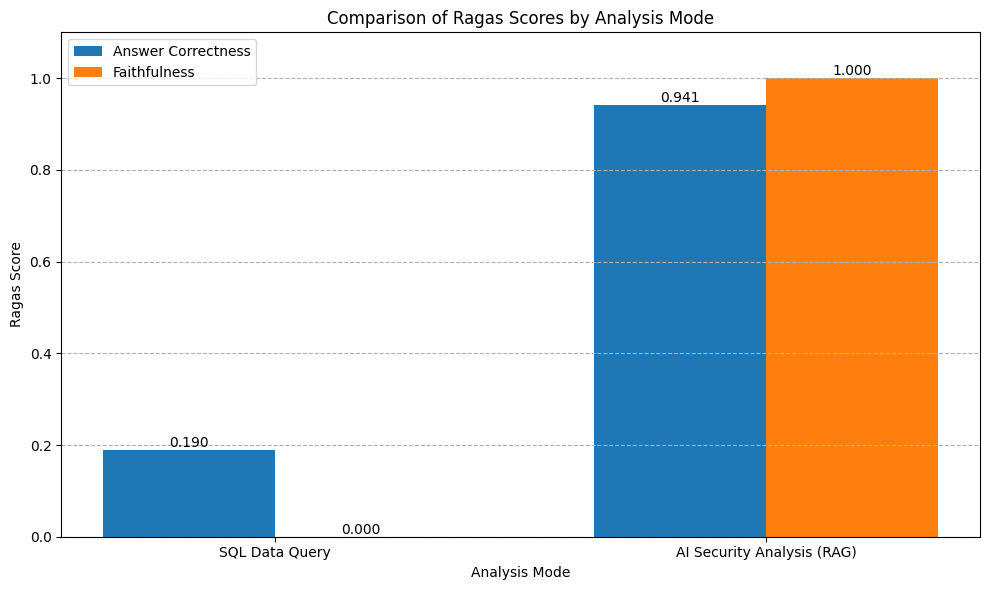

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure sql_score and rag_score are available from previous cells
if 'sql_score' in globals() and 'rag_score' in globals():
    print("Visualizing Ragas scores...")

    # Convert the scores to dictionaries for easier handling
    sql_scores_dict = sql_score.to_pandas().iloc[0].to_dict() # sql_score is likely a Dataset, convert to pandas
    rag_scores_dict = rag_score.to_pandas().iloc[0].to_dict()

    # Prepare data for plotting
    modes = ['SQL Data Query', 'AI Security Analysis (RAG)']
    metrics = ['answer_correctness', 'faithfulness'] # Only these two metrics are common/calculated

    # Extract scores, handling metrics that might not be present in both
    sql_correctness = sql_scores_dict.get('answer_correctness', 0) # Default to 0 if not found
    sql_faithfulness = sql_scores_dict.get('faithfulness', 0) # Faithfulness wasn't calculated for SQL, expect 0

    rag_correctness = rag_scores_dict.get('answer_correctness', 0)
    rag_faithfulness = rag_scores_dict.get('faithfulness', 0)


    correctness_scores = [sql_correctness, rag_correctness]
    faithfulness_scores = [sql_faithfulness, rag_faithfulness]


    # Create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    index = range(len(modes))

    bar1 = ax.bar(index, correctness_scores, bar_width, label='Answer Correctness')
    bar2 = ax.bar([i + bar_width for i in index], faithfulness_scores, bar_width, label='Faithfulness')

    ax.set_xlabel('Analysis Mode')
    ax.set_ylabel('Ragas Score')
    ax.set_title('Comparison of Ragas Scores by Analysis Mode')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(modes)
    ax.set_ylim(0, 1.1) # Scores are between 0 and 1

    # Add score values on top of the bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

    autolabel(bar1)
    autolabel(bar2)


    ax.legend()
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

else:
    print("Ragas scores (sql_score and rag_score) not found. Please run previous cells to calculate them.")

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://huggingface.co/llava-hf/llava-v1.6-34b-hf/discussions/8">https://huggingface.co/llava-hf/llava-v1.6-34b-hf/discussions/8</a></li>
  <li><a href="https://github.com/Equipo45/hf-example">https://github.com/Equipo45/hf-example</a></li>
  </ol>
</div>